In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import janus.pvr.python_util.io_utils as io_utils
import janus.pvr.python_util.geometry_utils as geometry_utils
import face3d
import vxl
import pix2face

/home/dec/projects/janus/src/python/janus/pvr/python_util/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/home/dec/projects/janus/src/python/janus/pvr/python_util/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/home/dec/projects/janus/src/python/janus/pvr/python_util/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
%matplotlib inline

### Estimate PNCC and Offsets using pix2face network

In [3]:
pix2face_data_dir = '../pix2face/data/'

In [4]:
model_fname = os.path.join(pix2face_data_dir, 'models/pix2face_unet_cuda75.pt')
model = pix2face.test.load_model(model_fname)

loading ../pix2face/data/models/pix2face_unet_cuda75.pt ...
...done.


In [5]:
img_fname = os.path.join(pix2face_data_dir, 'CASIA_0000107_004.jpg')
img = io_utils.imread(img_fname)
outputs = pix2face.test.test(model, [img,])
pncc = outputs[0][0]
offsets = outputs[0][1]

In [6]:
pncc_rgb = pncc / 300.0 + 0.5
offsets_rgb = offsets / 60.0 + 0.5

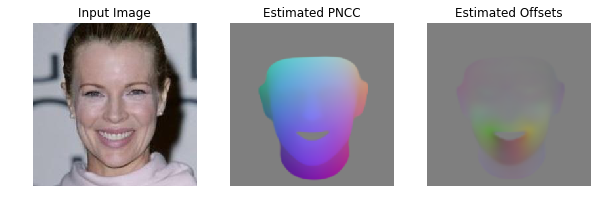

In [7]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(pncc_rgb)
ax[1].set_title('Estimated PNCC')
ax[2].imshow(offsets_rgb)
ax[2].set_title('Estimated Offsets')
for a in ax:
    a.axis('off')

In [8]:
pvr_data_dir = '../janus/components/pvr/data_3DMM/'
debug_dir = ''
debug_mode = False

In [9]:
# load needed data files
head_mesh = face3d.head_mesh(pvr_data_dir)
subject_components = np.load(os.path.join(pvr_data_dir, 'pca_components_subject.npy'))
expression_components = np.load(os.path.join(pvr_data_dir, 'pca_components_expression.npy'))
subject_ranges = np.load(os.path.join(pvr_data_dir,'pca_coeff_ranges_subject.npy'))
expression_ranges = np.load(os.path.join(pvr_data_dir,'pca_coeff_ranges_expression.npy'))
renderer = face3d.mesh_renderer()

In [10]:
# create coefficient estimator
coeff_estimator = face3d.media_coefficient_from_PNCC_and_offset_estimator(head_mesh, subject_components, expression_components, subject_ranges, expression_ranges, debug_mode, debug_dir)

### Estimate Coefficients from PNCC and Offsets

In [11]:
# estimate coefficients
img_ids = ['img0',]
coeffs = coeff_estimator.estimate_coefficients_perspective(img_ids, [pncc,], [offsets,])

In [12]:
# render synthetic image with estimated coefficients
green_tex = np.zeros((64,64,3), np.uint8)
green_tex[:,:,1] = 255

head_mesh.apply_coefficients(subject_components, expression_components, coeffs.subject_coeffs(), coeffs.expression_coeffs(0))
meshes = head_mesh.meshes()
for mesh in meshes:
    mesh.set_texture(green_tex)

renderer.render_perspective(meshes, coeffs.camera(0))
render = renderer.get_last_render()

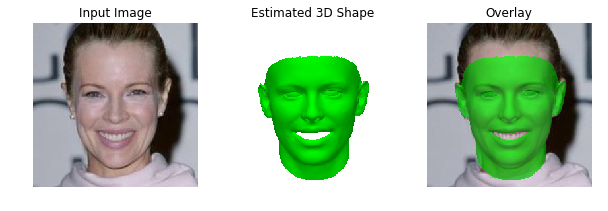

In [13]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(render)
ax[1].set_title('Estimated 3D Shape')
mask = render[:,:,3] > 0
blended = np.array(img)
img_weight = 0.3
blended[mask] = blended[mask]*img_weight + render[mask,0:3]*(1.0 - img_weight)
ax[2].imshow(blended)
ax[2].set_title('Overlay')
for a in ax:
    a.axis('off')

### Render 3D-Jittered Images

In [14]:
jitterer = face3d.media_jitterer_perspective([img,], coeffs, head_mesh, subject_components, expression_components, renderer, "")

In [15]:
new_expression_coeffs = np.zeros_like(coeffs.expression_coeffs(0))
# manually alter expression
new_expression_coeffs[1] = 2.0
new_expression_coeffs[2] = -2.0
new_expression_coeffs[14] = 1.5
render_neutral = jitterer.render_perspective(coeffs.camera(0), coeffs.subject_coeffs(), new_expression_coeffs, subject_components, expression_components)


In [16]:
delta_R = vxl.vgl_rotation_3d(geometry_utils.Euler_angles_to_quaternion(np.pi/3, 0, 0, order='YXZ'))
cam = coeffs.camera(0)
new_R = cam.rotation * delta_R
new_cam = face3d.perspective_camera_parameters(cam.focal_len, cam.principal_point, new_R, cam.translation, cam.nx, cam.ny)
render_rot = jitterer.render_perspective(new_cam, coeffs.subject_coeffs(), coeffs.expression_coeffs(0), subject_components, expression_components)

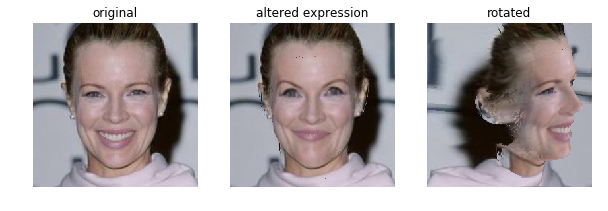

In [17]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img)
ax[0].set_title('original')
ax[1].imshow(render_neutral[:,:,0:3])
ax[1].set_title('altered expression')
ax[2].imshow(render_rot[:,:,0:3])
ax[2].set_title('rotated')
for a in ax:
    a.axis('off')